# Extracting properties along a section

We'll again NEMO into a dataset that is compatible with [XGCM](https://xgcm.readthedocs.io/en/latest/) via [Xorca](https://github.com/willirath/xorca).

## Tech preamble

Import modules and set up a Dask cluster.

In [1]:
from dask.distributed import Client, wait
import dask
from xorca_lonlat2ij import get_ij
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from xorca.lib import load_xorca_dataset
import xarray as xr

In [2]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=12e9)
client

/opt/tljh/user/envs/py3_euler/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:36787 Dashboard: /user/workshop019/proxy/32867/status,Cluster Workers: 1 Cores: 8 Memory: 12.00 GB


## Experiment parameters

In [3]:
# parameters

erda_data_path = Path("/data/erda/")
global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = ""

restrict_years = "201[0-1]"  # restricts to 2010 and 2011

## Find relevant data files

In [4]:
data_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_*.nc")
))
aux_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}[m,n]*.nc")
))

In [5]:
print(f"found {len(data_files)} data files")
print(f"found {len(aux_files)} aux files")
data_files

found 6 data files
found 4 aux files


[PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20100101_20101231_grid_T.nc'),
 PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20100101_20101231_grid_U.nc'),
 PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20100101_20101231_grid_V.nc'),
 PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20110101_20111231_grid_T.nc'),
 PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20110101_20111231_grid_U.nc'),
 PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20110101_20111231_grid_V.nc')]

In [6]:
etopo_data_file = erda_data_path / "ETOPO1/v1.x.x/data/ETOPO1_Ice_g_gmt4.nc"

## Open (virtual) datasets

In [7]:
with dask.config.set(scheduler='synchronous'):
    ds_xorca = load_xorca_dataset(
        data_files=data_files, aux_files=aux_files,
        decode_cf=True,
        input_ds_chunks={"time_counter": 3, "t": 3,
                       "z": 23, "Z": 23,
                       "deptht": 23, "depthu": 23,
                       "depthv": 23, "depthw": 23,
                       "y": 601, "Y": 601,
                       "x": 500, "X": 500},
        target_ds_chunks={"t": 3,
                        "z_c": 23, "z_l": 23,
                        "y_c": 601, "y_r": 601,
                        "x_c": 500, "x_r": 500})

In [8]:
display(ds_xorca)
print(ds_xorca.nbytes / 1e9, "GB")

<xarray.Dataset>
Dimensions:   (t: 24, x_c: 1440, x_r: 1440, y_c: 1019, y_r: 1019, z_c: 46, z_l: 46)
Coordinates:
    llat_cc   (y_c, x_c) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llon_rr   (y_r, x_r) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llat_rr   (y_r, x_r) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    depth_c   (z_c) float64 dask.array<chunksize=(23,), meta=np.ndarray>
    llat_rc   (y_r, x_c) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llat_cr   (y_c, x_r) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llon_cr   (y_c, x_r) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llon_rc   (y_r, x_c) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    llon_cc   (y_c, x_c) float32 dask.array<chunksize=(601, 500), meta=np.ndarray>
    depth_l   (z_l) float64 dask.array<chunksize=(23,), meta=np.ndarray>
  * y_r       (y_r) float64 1.5 2.5 3.5 4.5 ... 1.018e+03 1.018e+03 1.02e+03
  * z_l       (z_l) float64 0.5 1.5 2.5 3.5 4.5 5.5 ... 41.5 42.5 43.5 44.5 45.5
  * x_r       (x_r) float64 1.5 2.5 3.5 4.5 ... 1.438e+03 1.44e+03 1.44e+03
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 ... 1013 1014 1015 1016 1017 1018 1019
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 ... 1434 1435 1436 1437 1438 1439 1440
  * z_c       (z_c) int64 1 2 3 4 5 6 7 8 9 10 ... 37 38 39 40 41 42 43 44 45 46
  * t         (t) datetime64[ns] 2010-01-16T12:00:00 ... 2011-12-16T12:00:00
    e1t       (y_c, x_c) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e2t       (y_c, x_c) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e3t       (z_c, y_c, x_c) float64 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    e1u       (y_c, x_r) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e2u       (y_c, x_r) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e3u       (z_c, y_c, x_r) float64 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    e1v       (y_r, x_c) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e2v       (y_r, x_c) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e3v       (z_c, y_r, x_c) float64 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    e1f       (y_r, x_r) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e2f       (y_r, x_r) float64 dask.array<chunksize=(601, 500), meta=np.ndarray>
    e3w       (z_l, y_c, x_c) float64 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    tmask     (z_c, y_c, x_c) int8 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    umask     (z_c, y_c, x_r) int8 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    vmask     (z_c, y_r, x_c) int8 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
    fmask     (z_c, y_r, x_r) int8 dask.array<chunksize=(23, 601, 500), meta=np.ndarray>
Data variables:
    sobowlin  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sohefldo  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sohefldp  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    somixhgt  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    somxl010  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sosaline  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    soshfldo  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sossheig  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sosstsst  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sowafldp  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sowaflup  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    sowindsp  (t, y_c, x_c) float32 dask.array<chunksize=(3, 601, 500), meta=np.ndarray>
    vosaline  (t, z_c, y_c, x_c) float32 dask.arra

30.462434608 GB


In [9]:
etopo_ds = xr.open_dataset(
    etopo_data_file,
    chunks={"y": 1000, "x": 1000}
)
display(etopo_ds)

<xarray.Dataset>
Dimensions:  (x: 21601, y: 10801)
Coordinates:
  * x        (x) float64 -180.0 -180.0 -180.0 -179.9 ... 179.9 180.0 180.0 180.0
  * y        (y) float64 -90.0 -89.98 -89.97 -89.95 ... 89.95 89.97 89.98 90.0
Data variables:
    z        (y, x) float64 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Attributes:
    Conventions:  COARDS/CF-1.0
    title:        ETOPO1_Ice_g_gmt4.grd
    GMT_version:  4.4.0
    node_offset:  0

## Define a section and find grid points along the section

In [10]:
vertices_lat = np.concatenate(
    (
        np.linspace(29.1, 29.1, 20)[:-1],
        np.linspace(29.1, 28.5, 20)
    )
)
vertices_lon = np.concatenate(
    (
        np.linspace(-18.50, -15.5, 20)[:-1],
        np.linspace(-15.5, -12.45, 20)
    )
)

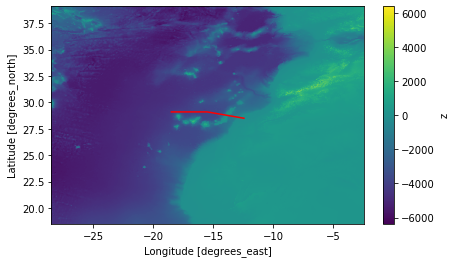

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

etopo_ds.sel(
    y=slice(vertices_lat.min() - 10, vertices_lat.max() + 10),
    x=slice(vertices_lon.min() - 10, vertices_lon.max() + 10)
).z.plot.pcolormesh(
    cmap="viridis",
    rasterized=True, ax=ax
)
ax.plot(vertices_lon, vertices_lat, "r");

## Find out releated indices

This can take some time, because `get_ij` will transform grid points on the (spherical) earth to 3D, and do the nearest-neighbor-lookup there.

In [12]:
vertices_j, vertices_i = get_ij(
    ds_xorca,
    np.vstack((vertices_lat, vertices_lon)).T,
    grid="T",
    xgcm=True,
    xarray_out=True
)

In [13]:
vertices_j.rename("vertices_j")
vertices_i.rename("vertices_i")

<xarray.DataArray 'vertices_i' (location: 39)>
array([1074, 1075, 1075, 1076, 1077, 1077, 1078, 1078, 1079, 1080, 1080,
       1081, 1082, 1082, 1083, 1083, 1084, 1085, 1085, 1086, 1087, 1087,
       1088, 1089, 1089, 1090, 1090, 1091, 1092, 1092, 1093, 1094, 1094,
       1095, 1096, 1096, 1097, 1098, 1098])
Dimensions without coordinates: location

## Extract data along section

In [14]:
full_temp_field = ds_xorca.votemper
full_temp_field = full_temp_field.where(ds_xorca.tmask != 0)
full_temp_field

full_U_field = ds_xorca.vozocrtx
full_U_field = full_U_field.where(ds_xorca.umask != 0)

full_V_field = ds_xorca.vomecrty
full_V_field = full_V_field.where(ds_xorca.vmask != 0)    

In [18]:
temp_along_section = full_temp_field.sel(
    y_c=vertices_j,
    x_c=vertices_i,
    method="nearest"
)

U_along_section = full_U_field.sel(
    y_c=vertices_j,
    x_r=vertices_i,
    method="nearest"
)
V_along_section = full_V_field.sel(
    y_r=vertices_j,
    x_c=vertices_i,
    method="nearest"
)

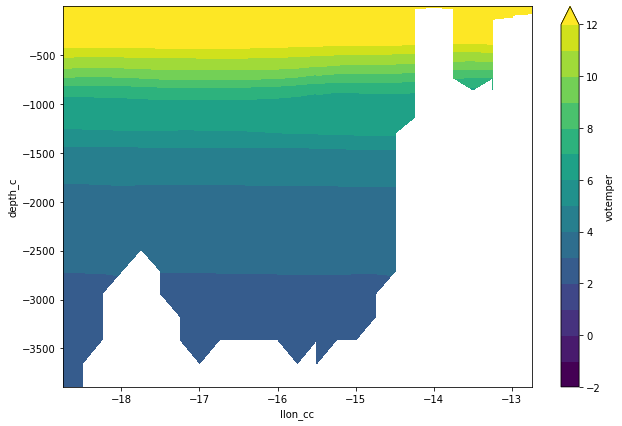

In [19]:
temp_along_section.mean("t").sel(z_c=slice(0, 38)).sortby("llon_cc").plot.contourf(
    x="llon_cc", y="depth_c",
    levels=np.linspace(-2, 12, 15), cmap="viridis", size=7
);

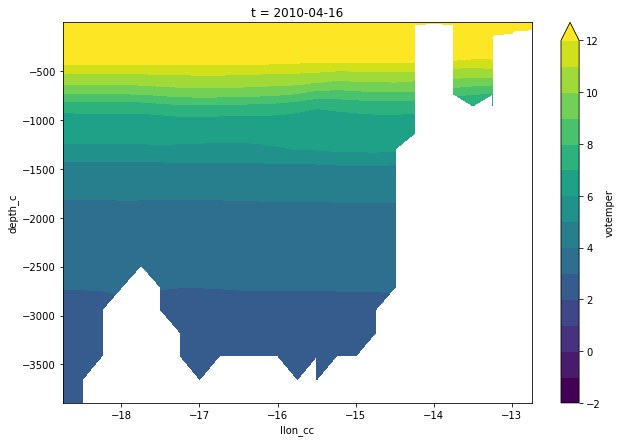

In [20]:
temp_along_section.isel(t=3).sel(z_c=slice(0, 38)).sortby("llon_cc").plot.contourf(
    x="llon_cc", y="depth_c",
    levels=np.linspace(-2, 12, 15), cmap="viridis", size=7
);

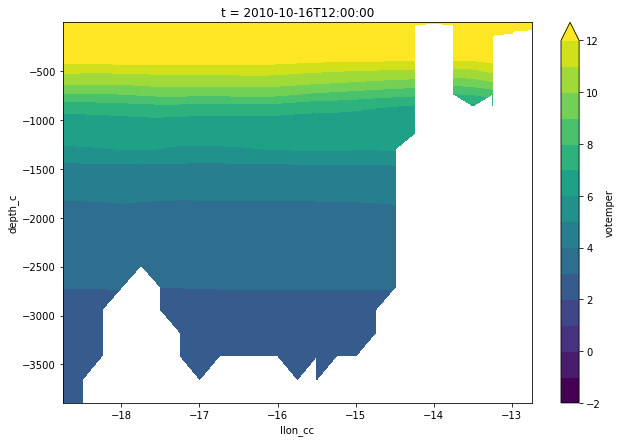

In [21]:
temp_along_section.isel(t=9).sel(z_c=slice(0, 38)).sortby("llon_cc").plot.contourf(
    x="llon_cc", y="depth_c",
    levels=np.linspace(-2, 12, 15), cmap="viridis", size=7
);

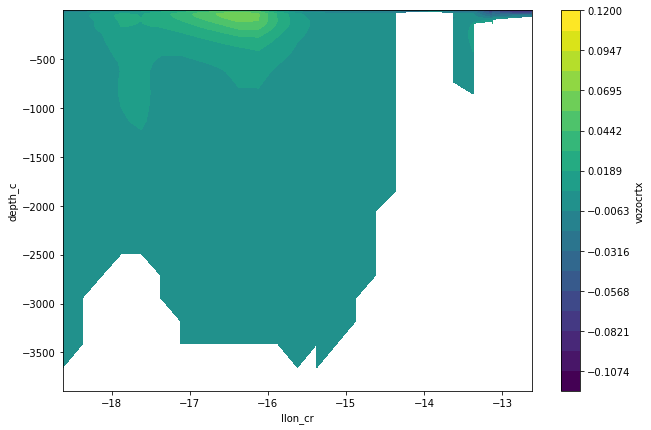

In [22]:
U_along_section.mean("t").sel(z_c=slice(0, 38)).sortby("llon_cr").plot.contourf(
    x="llon_cr", y="depth_c",levels=np.linspace(-0.12, 0.12, 20), cmap="viridis", size=7);

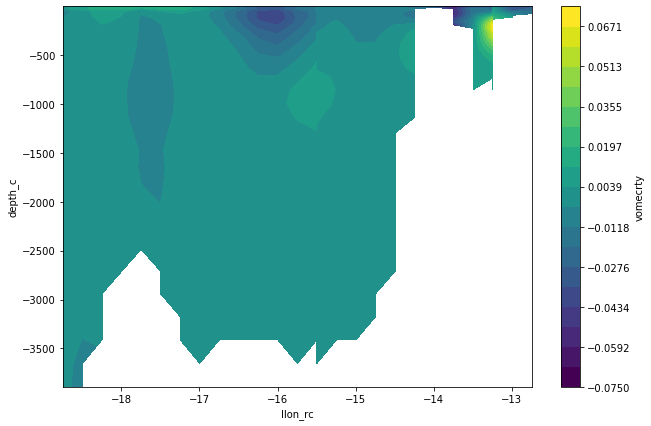

In [25]:
V_along_section.mean("t").sel(z_c=slice(0, 38)).sortby("llon_rc").plot.contourf(
    x="llon_rc", y="depth_c",levels=np.linspace(-0.075, 0.075, 20), cmap="viridis", size=7);